In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from transformers import DistilBertModel, DistilBertTokenizer
from PIL import Image
import numpy as np
import pandas as pd
import re
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import string

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f'Using device: {device}')

In [2]:
import spacy

# Load SpaCy for NER filtering
nlp = spacy.load("en_core_web_sm")

# List of trigger phrases that will cause everything following to be removed
trigger_phrases = [
    "sitting",
    "on top of",
    "placed on",
    "lying on",
    "next to"
]

# Function to clean the generated text (captions)
def clean_generated_text(text):
    # Step 1: Remove special tokens (if applicable)
    text = text.replace('<PAD>', '').replace('<SEP>', '').replace('<CLS>', '').strip()

    # Step 2: Convert to lowercase
    text = text.lower()

    # Step 3: Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Step 4: Remove numbers
    text = re.sub(r'\d+', '', text)

    # Step 5: Remove everything after the trigger phrases
    for phrase in trigger_phrases:
        if phrase in text:
            text = text.split(phrase)[0]
            break  # Stop after removing everything following the first trigger phrase

    # Step 6: Remove location entities (NER filtering)
    doc = nlp(text)
    filtered_text = " ".join([token.text for token in doc if token.ent_type_ not in ['LOC', 'GPE']])

    # Step 7: Final cleanup of extra spaces
    filtered_text = " ".join(filtered_text.split())

    return filtered_text.strip()

In [ ]:
# Function to detect the base directory depending on the PC
def detect_base_directory():
    possible_dirs = [
        r"/work/TALC/enel645_2024f/garbage_data",  # Directory on TALC cluster
        r"../../data/enel645_2024f/garbage_data"  # Directory on LAPTOP
    ]

    for base_dir in possible_dirs:
        if os.path.exists(base_dir):
            print(f"Using base directory: {base_dir}")
            return base_dir

    raise ValueError("No valid base directory found.")

# Base directory detection
base_dir = detect_base_directory()

# Define the train, val, and test directories
train_dir = os.path.join(base_dir, "CVPR_2024_dataset_Train")
val_dir = os.path.join(base_dir, "CVPR_2024_dataset_Val")
test_dir = os.path.join(base_dir, "CVPR_2024_dataset_Test")

# Function to load data with captions
# Function to load data with captions
def load_data_with_captions(data_dir, captions_file):
    image_paths = []
    texts = []
    labels = []
    label_map = {"Black": 0, "Blue": 1, "Green": 2, "TTR": 3}
    
    # Load captions from CSV
    captions_df = pd.read_csv(captions_file)
    captions_map = {row['image']: row['description'] for _, row in captions_df.iterrows()}
    
    for label_name, label_idx in label_map.items():
        folder_path = os.path.join(data_dir, label_name)
        if not os.path.isdir(folder_path):
            continue

        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(folder_path, filename)
                image_paths.append(image_path)

                # Get the generated caption from the CSV file or fall back to filename if no caption exists
                caption = captions_map.get(image_path, None)
                if caption:
                    text_description = caption
                else:
                    # Fallback to filename-based description
                    file_name_no_ext, _ = os.path.splitext(filename)
                    text_description = re.sub(r'\d+', '', file_name_no_ext.replace('_', ' '))
                
                # Clean the text description using the function
                cleaned_text = clean_generated_text(text_description)
                texts.append(cleaned_text)

                labels.append(label_idx)

    return np.array(image_paths), np.array(texts), np.array(labels)

# Load data with generated captions for training, validation, and testing
train_image_paths, train_texts, train_labels = load_data_with_captions(train_dir, 'train_image_descriptions.csv')
val_image_paths, val_texts, val_labels = load_data_with_captions(val_dir, 'val_image_descriptions.csv')
test_image_paths, test_texts, test_labels = load_data_with_captions(test_dir, 'test_image_descriptions.csv')

# Print out some information about the detected paths and loaded data
print(f"Training data: {len(train_image_paths)} images")
print(f"Validation data: {len(val_image_paths)} images")
print(f"Testing data: {len(test_image_paths)} images")


In [7]:

# Define the custom dataset
class MultimodalDataset(Dataset):
    def __init__(self, image_paths, texts, labels, transform=None, tokenizer=None, max_len=24):
        self.image_paths = image_paths
        self.texts = texts
        self.labels = labels
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Tokenize text
        text = str(self.texts[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        label = self.labels[idx]

        return {
            'image': image,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Data augmentation and preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Create datasets and dataloaders
train_dataset = MultimodalDataset(train_image_paths, train_texts, train_labels, transform=transform, tokenizer=tokenizer)
val_dataset = MultimodalDataset(val_image_paths, val_texts, val_labels, transform=transform, tokenizer=tokenizer)
test_dataset = MultimodalDataset(test_image_paths, test_texts, test_labels, transform=transform, tokenizer=tokenizer)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:

# Multimodal model combining ResNet50 and DistilBERT
class MultimodalModel(nn.Module):
    def __init__(self, num_classes):
        super(MultimodalModel, self).__init__()
        # Load pretrained ResNet50 model
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()
        self.resnet_feature_dim = 2048

        # Load DistilBERT model
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.distilbert_feature_dim = 768

        # Fully connected layers for combining features
        self.fc = nn.Sequential(
            nn.Linear(self.resnet_feature_dim + self.distilbert_feature_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
            

    def forward(self, images, input_ids, attention_mask):
        # Extract image features
        image_features = self.resnet(images)
        # Extract text features
        text_features = self.distilbert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]

        # Concatenate image and text features
        combined_features = torch.cat((image_features, text_features), dim=1)

        # Pass through fully connected layers
        output = self.fc(combined_features)
        return output

# Hyperparameters and model setup
num_classes = 4
learning_rate = 2e-5
num_epochs = 10

# Count the number of files in each class directory
label_map = {"Black": 0, "Blue": 1, "Green": 2, "TTR": 3}
class_counts = np.zeros(len(label_map), dtype=np.int32)
for label_name, label_idx in label_map.items():
    folder_path = os.path.join(train_dir, label_name)
    if os.path.isdir(folder_path):
        class_counts[label_idx] = len([f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

# Calculate the class weights using inverse frequency
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()  # Normalize to sum to 1
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Print the class counts and weights
for class_name, count, weight in zip(label_map.keys(), class_counts, class_weights):
    print(f'Class {class_name}: {count} samples, Weight: {weight:.4f}')

model = MultimodalModel(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


In [ ]:

# Training with early stopping
best_val_loss = float('inf')
patience = 5
epochs_no_improve = 0

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(images, input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy = accuracy_score(y_true, y_pred)
    val_precision = precision_score(y_true, y_pred, average='weighted')
    val_recall = recall_score(y_true, y_pred, average='weighted')
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val Prec: {val_precision:.4f}, Val Recall: {val_recall:.4f}')

    scheduler.step()

    # Check for early stopping
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), 'best_multimodal_model.pth')
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break


/var/folders/_m/p9lrk0vj7l9dgy03bgtt6sm80000gn/T/ipykernel_63227/2649872260.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_multim

215
Batch 0 / 215
Batch 1 / 215
Batch 2 / 215
Batch 3 / 215
Batch 4 / 215
Batch 5 / 215
Batch 6 / 215
Batch 7 / 215
Batch 8 / 215
Batch 9 / 215
Batch 10 / 215
Batch 11 / 215
Batch 12 / 215
Batch 13 / 215
Batch 14 / 215
Batch 15 / 215
Batch 16 / 215
Batch 17 / 215
Batch 18 / 215
Batch 19 / 215
Batch 20 / 215
Batch 21 / 215
Batch 22 / 215
Batch 23 / 215
Batch 24 / 215
Batch 25 / 215
Batch 26 / 215
Batch 27 / 215
Batch 28 / 215
Batch 29 / 215
Batch 30 / 215
Batch 31 / 215
Batch 32 / 215
Batch 33 / 215
Batch 34 / 215
Batch 35 / 215
Batch 36 / 215
Batch 37 / 215
Batch 38 / 215
Batch 39 / 215
Batch 40 / 215
Batch 41 / 215
Batch 42 / 215
Batch 43 / 215
Batch 44 / 215
Batch 45 / 215
Batch 46 / 215
Batch 47 / 215
Batch 48 / 215
Batch 49 / 215
Batch 50 / 215
Batch 51 / 215
Batch 52 / 215
Batch 53 / 215
Batch 54 / 215
Batch 55 / 215
Batch 56 / 215
Batch 57 / 215
Batch 58 / 215
Batch 59 / 215
Batch 60 / 215
Batch 61 / 215
Batch 62 / 215
Batch 63 / 215
Batch 64 / 215
Batch 65 / 215
Batch 66 / 215
B

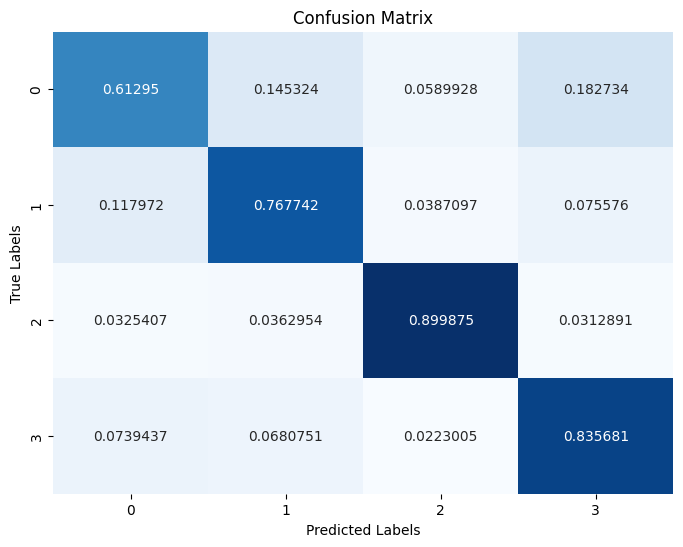

Test Accuracy: 0.7840, Test Precision: 0.7831, Test Recall: 0.7840


In [17]:

# Load the best model and evaluate on the test set
model.load_state_dict(torch.load('best_multimodal_model.pth', map_location=torch.device('mps')))
model.eval()
test_predictions = []
i=0
print(len(test_loader))
with torch.no_grad():
    for batch in test_loader:
        print(f"Batch {i} / {len(test_loader)}")
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(images, input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)
        test_predictions.extend(preds.cpu().numpy())
        i+=1

# Confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Normalize the confusion matrix by row (true labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Test set metrics
test_accuracy = accuracy_score(test_labels, test_predictions)
test_precision = precision_score(test_labels, test_predictions, average='weighted')
test_recall = recall_score(test_labels, test_predictions, average='weighted')
print(f'Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}')
